<a href="https://colab.research.google.com/github/cicada0521/Finance/blob/main/Basic_Algo_Trading_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
<ipython-input-1-ab25bc1176c3>:51: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['signal'][short_window:] = np.where(
<ipython-input-1-ab25bc1176c3>:51: SettingWith


1. Moving Average Crossover Strategy


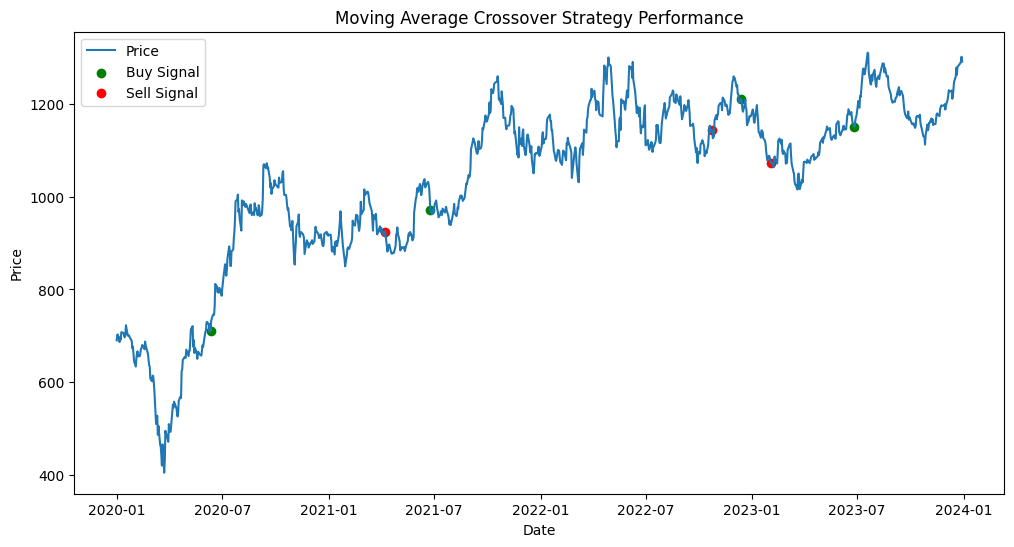

{'Cumulative Returns': 0.5268825771825645, 'Annual Returns': 0.11350600033053104, 'Sharpe Ratio': 0.5963416178375232, 'Max Drawdown': -0.43012363810663}

2. Mean Reversion Strategy


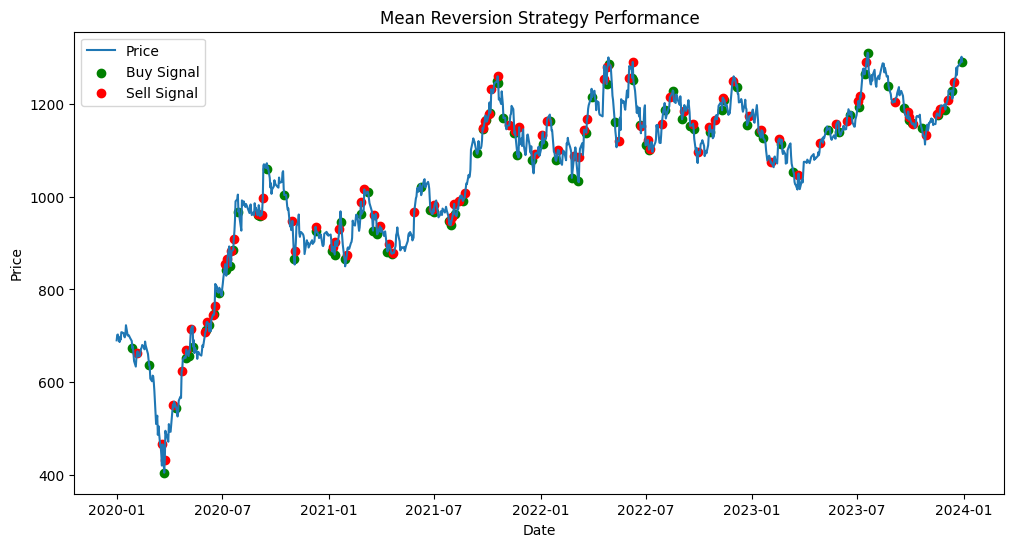

{'Cumulative Returns': -0.3559422621262367, 'Annual Returns': -0.10574631988380656, 'Sharpe Ratio': -0.5266063200129297, 'Max Drawdown': -0.366498068788091}

3. Momentum Strategy


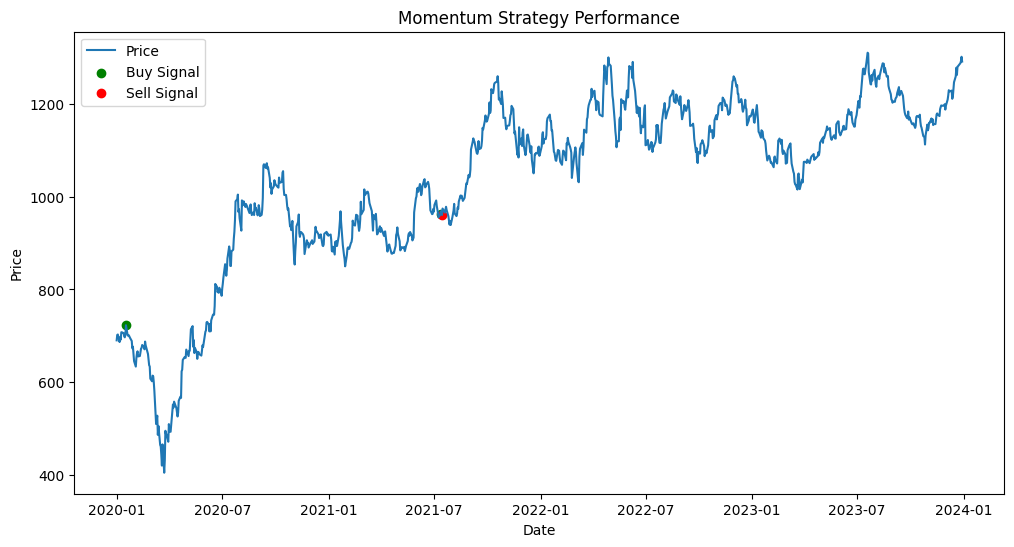

{'Cumulative Returns': 0.7339453965373335, 'Annual Returns': 0.15006584742336182, 'Sharpe Ratio': 0.6049078518374624, 'Max Drawdown': -0.8063103655248167}


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class AlgorithmicTradingStrategies:
    def __init__(self, ticker, start_date, end_date):
        """
        Initialize the trading strategies with stock data

        :param ticker: Stock ticker symbol
        :param start_date: Start date for historical data
        :param end_date: End date for historical data
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = self.fetch_stock_data()

    def fetch_stock_data(self):
        """
        Fetch historical stock data

        :return: Pandas DataFrame with stock data
        """
        try:
            stock_data = yf.download(self.ticker,
                                     start=self.start_date,
                                     end=self.end_date)
            return stock_data
        except Exception as e:
            print(f"Error fetching stock data: {e}")
            return None

    def moving_average_crossover_strategy(self, short_window=50, long_window=200):
        """
        Moving Average Crossover Trading Strategy

        :param short_window: Short-term moving average window
        :param long_window: Long-term moving average window
        :return: Trading signals and performance metrics
        """
        # Calculate moving averages
        signals = pd.DataFrame(index=self.data.index)
        signals['price'] = self.data['Close']
        signals['short_mavg'] = signals['price'].rolling(window=short_window, min_periods=1).mean()
        signals['long_mavg'] = signals['price'].rolling(window=long_window, min_periods=1).mean()

        # Generate trading signals
        signals['signal'] = 0
        signals['signal'][short_window:] = np.where(
            signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1, 0
        )
        signals['positions'] = signals['signal'].diff()

        # Calculate returns
        signals['strategy_returns'] = signals['price'].pct_change() * signals['signal'].shift(1)

        return signals

    def mean_reversion_strategy(self, window=20, num_std=1.5):
        """
        Mean Reversion Trading Strategy

        :param window: Rolling window for calculating mean and std
        :param num_std: Number of standard deviations for entry/exit
        :return: Trading signals and performance metrics
        """
        signals = pd.DataFrame(index=self.data.index)
        signals['price'] = self.data['Close']

        # Calculate rolling mean and standard deviation
        signals['rolling_mean'] = signals['price'].rolling(window=window).mean()
        signals['rolling_std'] = signals['price'].rolling(window=window).std()

        # Generate trading signals
        signals['upper_band'] = signals['rolling_mean'] + (num_std * signals['rolling_std'])
        signals['lower_band'] = signals['rolling_mean'] - (num_std * signals['rolling_std'])

        signals['signal'] = 0
        signals.loc[signals['price'] > signals['upper_band'], 'signal'] = -1  # Sell
        signals.loc[signals['price'] < signals['lower_band'], 'signal'] = 1   # Buy

        signals['positions'] = signals['signal'].diff()
        signals['strategy_returns'] = signals['price'].pct_change() * signals['signal'].shift(1)

        return signals

    def momentum_strategy(self, window=12):
        """
        Momentum Trading Strategy

        :param window: Momentum calculation window
        :return: Trading signals and performance metrics
        """
        signals = pd.DataFrame(index=self.data.index)
        signals['price'] = self.data['Close']

        # Calculate momentum
        signals['momentum'] = signals['price'].pct_change(window)

        # Generate trading signals
        signals['signal'] = 0
        signals.loc[signals['momentum'] > 0, 'signal'] = 1   # Buy
        signals.loc[signals['momentum'] < 0, 'signal'] = -1  # Sell

        signals['positions'] = signals['signal'].diff()
        signals['strategy_returns'] = signals['price'].pct_change() * signals['signal'].shift(1)

        return signals

    def plot_strategy(self, signals, strategy_name):
        """
        Plot strategy performance

        :param signals: DataFrame with strategy signals
        :param strategy_name: Name of the trading strategy
        """
        plt.figure(figsize=(12, 6))
        plt.title(f'{strategy_name} Strategy Performance')
        plt.plot(signals.index, signals['price'], label='Price')
        plt.scatter(signals.index[signals['positions'] == 1],
                    signals['price'][signals['positions'] == 1],
                    color='green', label='Buy Signal')
        plt.scatter(signals.index[signals['positions'] == -1],
                    signals['price'][signals['positions'] == -1],
                    color='red', label='Sell Signal')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    def calculate_strategy_performance(self, signals):
        """
        Calculate strategy performance metrics

        :param signals: DataFrame with strategy signals
        :return: Dictionary of performance metrics
        """
        cumulative_returns = (1 + signals['strategy_returns']).cumprod() - 1

        return {
            'Cumulative Returns': cumulative_returns.iloc[-1],
            'Annual Returns': (1 + cumulative_returns.iloc[-1]) ** (252 / len(cumulative_returns)) - 1,
            'Sharpe Ratio': np.sqrt(252) * signals['strategy_returns'].mean() / signals['strategy_returns'].std(),
            'Max Drawdown': (cumulative_returns - cumulative_returns.cummax()).min()
        }

def main():
    # Example usage with Reliance Industries (RELIANCE.NS)
    ticker = 'RELIANCE.NS'
    start_date = '2020-01-01'
    end_date = '2023-12-31'

    # Initialize trading strategies
    trading_strategies = AlgorithmicTradingStrategies(ticker, start_date, end_date)

    # Moving Average Crossover Strategy
    print("\n1. Moving Average Crossover Strategy")
    ma_signals = trading_strategies.moving_average_crossover_strategy()
    trading_strategies.plot_strategy(ma_signals, 'Moving Average Crossover')
    print(trading_strategies.calculate_strategy_performance(ma_signals))

    # Mean Reversion Strategy
    print("\n2. Mean Reversion Strategy")
    mr_signals = trading_strategies.mean_reversion_strategy()
    trading_strategies.plot_strategy(mr_signals, 'Mean Reversion')
    print(trading_strategies.calculate_strategy_performance(mr_signals))

    # Momentum Strategy
    print("\n3. Momentum Strategy")
    mom_signals = trading_strategies.momentum_strategy()
    trading_strategies.plot_strategy(mom_signals, 'Momentum')
    print(trading_strategies.calculate_strategy_performance(mom_signals))

if __name__ == '__main__':
    main()